In [1]:
%load_ext autoreload
%autoreload 2
%load_ext yamlmagic

In [2]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Helpful plotting functions
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne

In [3]:
import sys
sys.path.append('../../UniverSeg')
sys.path.append('../../ScribblePrompt')
sys.path.append('../')


In [16]:
!python -m pip install -r ../../UniverSeg/requirements.txt
# Inference-only requirements
!python -m pip install -r ../../ScribblePrompt/requirements.txt
# Includes dependencies for prompt simulation
!python -m pip install -r ../../ScribblePrompt/requirements_training.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 33.9 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]
  Cloning https://github.com/dalcalab/voxynth.git to /tmp/pip-install-lp4ztec1/voxynth_8cb02bfadbb8464bb973b5a41267b53c
  Running command git clone --filter=blob:none --quiet https://github.com/dalcalab/voxynth.git /tmp/pip-install-lp4ztec1/voxynth_8cb02bfadbb8464bb973b5a41267b53c
  Resolved https://github.com/dalcalab/voxynth.git to commit 6253700daf7fc913eef12c08fed6f8bc992272b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/JJGO/pylot.git to /tmp/pip-install-lp4ztec1/pylot_13324ce174474e39afce0d5cb6dae575
  Running command git clone --filter=blob:none --quiet https://github.com/JJGO/pylot.git /tmp/pip-install-lp4ztec1/pyl

In [4]:
import universeg
import scribbleprompt
import multiverseg

# Data Loader

In [5]:
from multiverseg.datasets.wbc import WBCDataset
import itertools

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 10

print(d_support)

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)
print(support_images.shape, support_labels.shape)

WBCDataset(dataset='JTSC', split='support', label='cytoplasm', support_frac=0.7)
torch.Size([10, 1, 128, 128]) torch.Size([10, 1, 128, 128])


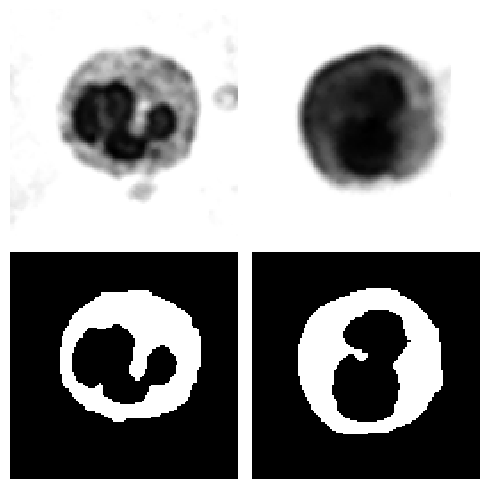

(<Figure size 500x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

In [6]:
n = 2
ne.plot.slices(
    [support_images[i].cpu() for i in range(n)]+\
    [support_labels[i].cpu() for i in range(n)],
    grid=(2,n), width=5
)

# Inference Examples

In [15]:
from multiverseg.models.sp_mvs import MultiverSeg

# Instantiate the model
model = MultiverSeg(version="v0")

# Baselines
from universeg import universeg
uvs = universeg(pretrained=True)

from scribbleprompt.models.unet import ScribblePromptUNet
sp = ScribblePromptUNet(version='v1')

torch.Size([1, 128, 128])


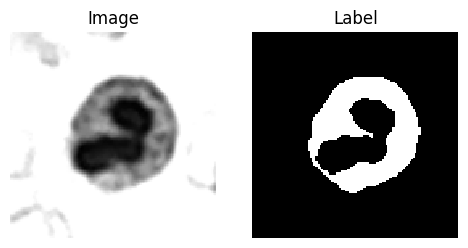

(<Figure size 500x250 with 2 Axes>,
 array([<Axes: title={'center': 'Image'}>,
        <Axes: title={'center': 'Label'}>], dtype=object))

In [7]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)
print(image.shape)

ne.plot.slices([image.cpu(), label.cpu()], width=5, titles=['Image', 'Label'])

## In-Context Segmentation

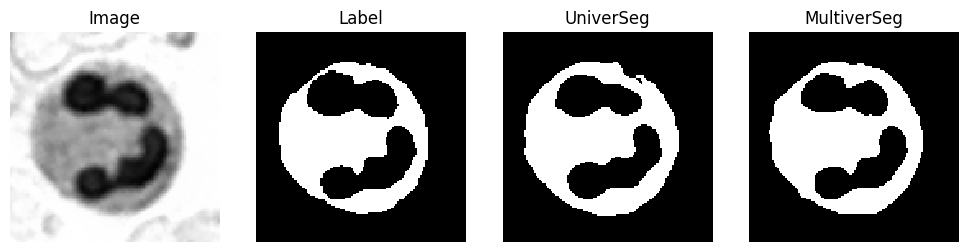

(<Figure size 1000x250 with 4 Axes>,
 array([<Axes: title={'center': 'Image'}>,
        <Axes: title={'center': 'Label'}>,
        <Axes: title={'center': 'UniverSeg'}>,
        <Axes: title={'center': 'MultiverSeg'}>], dtype=object))

In [39]:
# run inference
yhat = model.predict(image[None], support_images[None], support_labels[None], return_logits=False).to('cpu')

# baseline
yhat_uvs = uvs(image[None], support_images[None], support_labels[None]).to('cpu').detach()
yhat_uvs = torch.sigmoid(yhat_uvs).squeeze()

# visualize
ne.plot.slices([image.cpu(), label.cpu(), yhat_uvs > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'UniverSeg', 'MultiverSeg'])

## Interactive Segmentation

In [34]:
%%yaml random_warm_start
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_pos_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
init_neg_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
correction_click_generators:
  - _class: scribbleprompt.interactions.clicks.ComponentCenterClick
    train: False
init_pos_click: 3
init_neg_click: 3
correction_clicks: 1
prob_bbox: 0.0
prob_click: 1.0
from_logits: True

<IPython.core.display.Javascript object>

In [35]:
from pylot.experiment.util import eval_config
prompt_generator = eval_config(random_warm_start)

In [36]:
prompts = prompt_generator(image[None], label[None])
print(prompts.keys())
clicks = {k:prompts.get(k) for k in ['point_coords', 'point_labels']}

dict_keys(['img', 'seg', 'point_coords', 'point_labels', 'x', 'y'])


In [ ]:
# run inference
# no support images and labels
yhat = model.predict(image[None], **clicks, return_logits=False).to('cpu')

# baseline
yhat_sp = sp.predict(image[None], **clicks).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat_sp > 0.5, yhat_uvs > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'ScribblePrompt', 'UniverSeg', 'MultiverSeg'], show=False)
show_points(clicks['point_coords'].cpu(), clicks['point_labels'].cpu(), ax=axes[0])
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/data/ddmg/users/gtorpey/envs/mvseg-ordering-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3812287/661623138.py", line 10, in <module>
    fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat_sp > 0.5, yhat_uvs > 0.5, yhat > 0.5], width=10,
  File "/data/ddmg/users/gtorpey/envs/mvseg-ordering-env/lib/python3.10/site-packages/neurite/py/plot.py", line 67, in slices
    titles = input_check(titles, nb_plots, 'titles')
  File "/data/ddmg/users/gtorpey/envs/mvseg-ordering-env/lib/python3.10/site-packages/neurite/py/plot.py", line 59, in input_check
    assert (inputs is None) or (len(inputs) == nb_plots) or (len(inputs) == 1), \
AssertionError: number of titles is incorrect

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/data/ddmg/users/gtorpey/envs/mvseg-or

## Interactive In-Context Segmentation

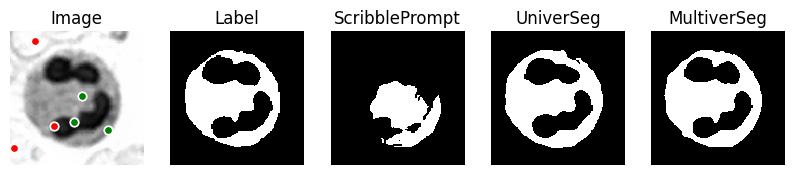

In [ ]:
# with support images
yhat = model.predict(image[None], support_images[None], support_labels[None], **clicks, return_logits=False).to('cpu')

# baseline
yhat_sp = sp.predict(image[None], **clicks).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat_sp > 0.5, yhat_uvs > 0.5, yhat > 0.5], width=10, 
               titles=['Image', 'Label', 'ScribblePrompt', 'UniverSeg', 'MultiverSeg'], show=False)
show_points(clicks['point_coords'].cpu(), clicks['point_labels'].cpu(), ax=axes[0])
plt.show()

## Multi-round Inference

In [20]:
# run inference
yhat = model.predict(image[None], support_images[None], support_labels[None], return_logits=True).to('cpu')

# Simulate corrections
corrections = prompt_generator.subsequent_prompt(
    # to use as an input to the model in the next iteration
    mask_pred = yhat,
    # to use for calculating error region & sampling interactions
    binary_mask_pred = (yhat>0).int(),
    prev_input = prompts
)
correction_clicks = {k:prompts.get(k) for k in ['point_coords', 'point_labels', 'mask_input']}

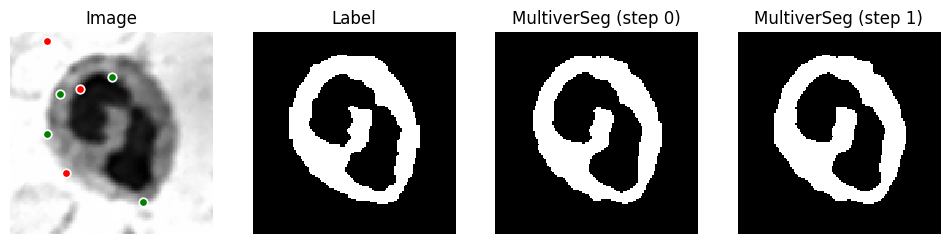

In [21]:
# Run inference
yhat2 = model.predict(image[None], support_images[None], support_labels[None], **correction_clicks, return_logits=False).to('cpu')

# visualize
from scribbleprompt.analysis.plot import show_mask,show_points,show_boxes,show_scribbles
fig,axes = ne.plot.slices([image.cpu(), label.cpu(), yhat > 0.5, yhat2 > 0.5], width=12, 
               titles=['Image', 'Label', 'MultiverSeg (step 0)', 'MultiverSeg (step 1)'], show=False)
show_points(correction_clicks['point_coords'].cpu(), correction_clicks['point_labels'].cpu(), ax=axes[0])
plt.show()